In [46]:
import os
import numpy as np
import pickle
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fitting.utils import get_lab_example
from fitting.utils import get_output_dirs

# Plot decoder $R^2$'s

### load results

In [24]:
# specify decoder directory
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet'}
lab = 'musall'
model_types = ['linear', 'ff']
expt_name = 'test_grid_search'

metrics = []
model_indx = 0
for model_type in model_types:

    get_lab_example(hparams, lab)
    
    _, _, expt_dir = get_output_dirs(
        hparams, model_class='neural-ae', expt_name=expt_name, model_type=model_type)

    # gather all versions
    def get_dirs(path):
        return next(os.walk(path))[1]
    versions = get_dirs(expt_dir)

    # load csv files with model metrics (saved out from test tube)
    for i, version in enumerate(versions):
        # read metrics csv file
        model_dir = os.path.join(expt_dir, version)
        try:
            metric = pd.read_csv(os.path.join(model_dir, 'metrics.csv'))
        except:
            continue
        # load model info
        with open(os.path.join(model_dir, 'meta_tags.csv'), mode='r') as f:
            hp = csv.reader(f)
            hparams = {rows[0]: rows[1] for rows in hp}
        # append model info to metrics ()
        version_num = version[8:]
        metric['version'] = str('version_%i' % model_indx + version_num)
        for key, val in hparams.items():
            metric[key] = val
        metrics.append(metric)
        
    model_indx += 10000  # assumes no more than 10k model versions in an experiment
# put everything in pandas dataframe
metrics_df = pd.concat(metrics, sort=False)

### Plot R2s as a function of lags/layers 
### (take best models over learning rate/L2 reg)

In [26]:
sns.set_style('white')
sns.set_context('talk')

# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]
best_models_list = []

if 'linear' not in model_types:
    hue = None
    
    # take min over val losses
    loss_mins = metrics_df.groupby(
        ['n_lags', 'learning_rate', 'l2_reg', 'version']).min().reset_index()
    n_lags = metrics_df.n_lags.unique()
    n_lags.sort()   
    for lag in n_lags:
        # get all models with this number of lags
        single_hp = loss_mins[loss_mins.n_lags==lag]
        # find best version from these models
        best_version = best_lr.iloc[single_hp.val_loss.idxmin()].version
        # index back into original data to grab test loss on all batches
        best_models_list.append(data_queried[data_queried.version==best_version])
else:
    hue = 'n_hid_layers'
    
    # take min over val losses
    loss_mins = metrics_df.groupby(
        ['n_lags', 'n_hid_layers', 'learning_rate', 'l2_reg', 'version']).min().reset_index()
    n_lags = metrics_df.n_lags.unique()
    n_lags.sort()
    n_hid_layers = metrics_df.n_hid_layers.unique()
    n_hid_layers.sort()
    for lag in n_lags:
        for layer in n_hid_layers:
            # get all models with this number of lags
            single_hp = loss_mins[(loss_mins.n_lags==lag) & (loss_mins.n_hid_layers==layer)]
            # find best version from these models
            best_version = loss_mins.iloc[single_hp.val_loss.idxmin()].version
            # index back into original data to grab test loss on all batches
            best_models_list.append(data_queried[data_queried.version==best_version])

best_models_df = pd.concat(best_models_list)

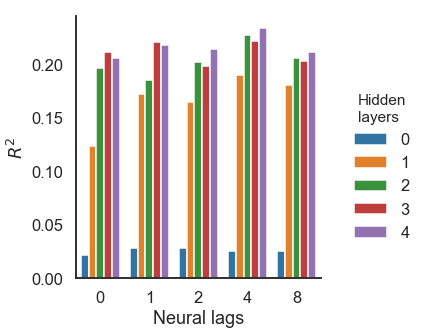

In [47]:
# PLOT
y_axis = 'test_r2' # 'test_loss' | 'test_r2'
plot_type = 'bar'
x_axis = 'n_lags'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=best_models_df, ci=None)
splt.ax.set_ylabel('$R^2$')
splt.ax.set_xlabel('Neural lags')
splt._legend.set_title('Hidden\nlayers')

save_file = str('/home/mattw/results/temp/%s_decoder_R2s' % lab)
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
    
plt.show()

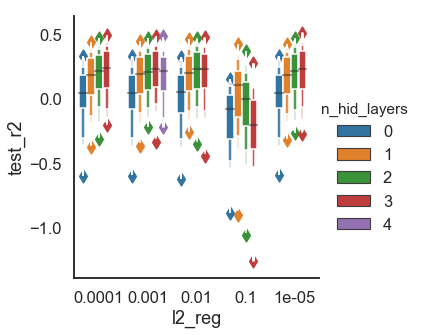

In [44]:
# look at reg vals/learning rate
measure = 'l2_reg'  # 'learning_rate' | 'l2_reg'

if measure == 'learning_rate':
    get_best = 'l2_reg'
else:
    get_best = 'learning_rate'
    
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]

# group by get_best, find avgs over all other hyperparams
best_meas = data_queried.groupby([get_best]).mean().reset_index()
# find the best value for get_best
best_meas = best_meas[
    best_meas['test_loss']==best_meas['test_loss'].min()][get_best].values[0]
# subsample data with this value
data_queried = data_queried[data_queried[get_best]==best_meas]

x_axis = measure
y_axis = 'test_r2' # 'test_loss' | 'test_r2'
plot_type = 'boxen'
hue = 'n_hid_layers'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)

# make movies

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/ae/conv/16_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/test_tube_data/test_grid_search/version_272/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000
processing frame 100
saving video
video saved to /home/mattw/results/temp/musall_neural_recon_ff.mp4


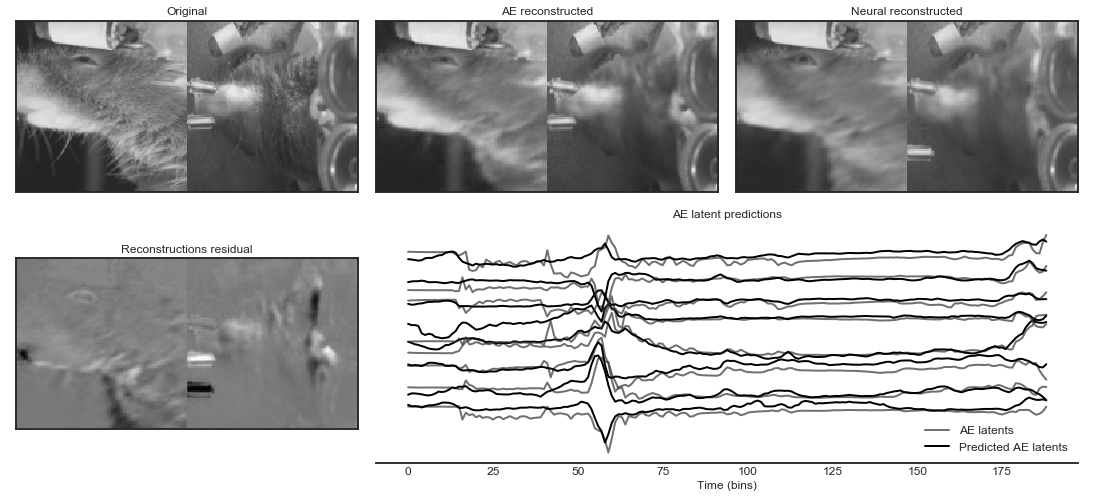

In [49]:
# from analyses.ae.movies import reconstruction
from fitting.utils import get_lab_example
from data.data_generator import ConcatSessionsGenerator
from analyses.ae.movies import make_neural_reconstruction_movie

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'ae_experiment_name': 'test_pt',
    'ae_model_class': 'ae',
    'ae_model_type': 'conv',
    'ae_version': 'best',
    'decoder_experiment_name': 'test_grid_search',
    'decoder_model_class': 'neural-ae',
    'decoder_model_type': 'ff',
    'decoder_version': 'best',
    'lib': 'pt'}

labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']

for lab in labs:
    get_lab_example(hparams, lab)
    # fastest way to get test trials
    data_generator = ConcatSessionsGenerator(
        hparams['data_dir'], hparams, 
        signals=['images'], transforms=[None], load_kwargs=[None],
        device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
    trial = data_generator.batch_indxs[0]['test'][4]

    save_file = str('/home/mattw/results/temp/%s_%02i_dim_neural_recon_%s' % lab)

    make_neural_reconstruction_movie(hparams, save_file=save_file, trial=trial)